In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import shutil
import re
#import pandas
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error
import math


import tensorflow as tf

from tensorflow.keras import layers
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)



# Codificación por Posición#
## $PE_{(pos,2i)}=\sin(pos/10000^{2i/d_{model}})$<br/>$PE_{(pos,2i+1)}=\cos(pos/10000^{2i/d_{model}})$ ##

In [2]:
def cogerAngulo(pos, i, d):
  ratiosAngulo = 1 / np.power(10000, (2 * (i//2)) / np.float32(d))
  return pos * ratiosAngulo

def codiciacionPosicional(posicion, d):
  angulos = cogerAngulo(np.arange(posicion)[:, np.newaxis], np.arange(d)[np.newaxis, :], d)
  
  angulos[:, 0::2] = np.sin(angulos[:, 0::2]) #Lo hacemos para los pares
  
  angulos[:, 1::2] = np.cos(angulos[:, 1::2]) #Lo hacemos para los impares
    
  posCodificados = angulos[np.newaxis, ...]
    
  return tf.cast(posCodificados, dtype=tf.float32)


## Mascaras ##
útiles para despreciar palabras que pueden afectar al comportamiento de la red

In [3]:
def crearMascaraEmpaquetada(secuencia):
    secuencia=tf.cast(tf.math.equal(secuencia,0), tf.float32)
    return secuencia[:, tf.newaxis, tf.newaxis, :]

def crearMascaraAlFrente(n): #Retorna una máscara diagonal de 0's en el triangulo inferior y de tamaño nxn
    mascara=1-tf.linalg.band_part(tf.ones((n,n)),-1,0)
    return mascara

# ATENCIÓN #
## $Atencion(Q,K,V)=softmax_k(\frac{QK^T}{(\sqrt{d_k})})V$ ##

In [4]:
#Este método calcula el producto escalar de matrices con la ecuación de Atención
def productoEscalarConAtencion(q,k,v, mascaraAtencion):
    matrizQK=tf.matmul(q,k,transpose_b=True)
    #Calculamos la profuncidad d
    dk=tf.cast(tf.shape(k)[-1],tf.float32)
    #Valor escalar de atención
    atencionEscalar=matrizQK/tf.math.sqrt(dk)

    #Sumamos la máscara de atención
    if(mascaraAtencion is not None):
        atencionEscalar+=(mascaraAtencion*-1e9) #el -1e9 es para generar un valor infinito.
    
    #Calculamos la función softmax y normalizamos al últmo eje
    pesosAtencion=tf.nn.softmax(atencionEscalar, axis=-1)

    salida=tf.matmul(pesosAtencion, v)

    return salida, pesosAtencion

In [5]:
class AtencionMultiple(tf.keras.layers.Layer):
  def __init__(self, d, numeroCabezas):
    super(AtencionMultiple, self).__init__()
    self.numeroCabezas = numeroCabezas
    self.d = d
    
    assert d % self.numeroCabezas == 0
    
    self.profundida = d // self.numeroCabezas #División entera
    
    self.wq = tf.keras.layers.Dense(d)
    self.wk = tf.keras.layers.Dense(d)
    self.wv = tf.keras.layers.Dense(d)
    
    self.capaDensa = tf.keras.layers.Dense(d)

  #  Divide la última dimensio dentro (numeroCabezas, profundidad) transponiendo el resultado
  # que tiene dimensioines (tamañoPaque, numeroCabezas, longitudSecuencia, profundidad)
  def dividirCabezas(self, x, tamañoPaquete):
    x = tf.reshape(x, (tamañoPaquete, -1, self.numeroCabezas, self.profundida))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mascara):
    tamañoPaquete = tf.shape(q)[0]
    
    q = self.wq(q)
    k = self.wk(k) 
    v = self.wv(v)
    
    q = self.dividirCabezas(q, tamañoPaquete)
    k = self.dividirCabezas(k, tamañoPaquete)
    v = self.dividirCabezas(v, tamañoPaquete)
    
    resultadoAtencion, pesosAtencion = productoEscalarConAtencion(q, k, v, mascara)
    
    resultadoAtencion = tf.transpose(resultadoAtencion, perm=[0, 2, 1, 3])

    concatenarAtenciones = tf.reshape(resultadoAtencion, (tamañoPaquete, -1, self.d))

    resultado = self.capaDensa(concatenarAtenciones)  
        
    return resultado, pesosAtencion

In [6]:
def redNeuronalHaciaDelante(d, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d)
  ])


In [7]:
class CapaCodificadora(tf.keras.layers.Layer):
  def __init__(self, d, numeroCabezas, dff, ratio=0.1):
    super(CapaCodificadora, self).__init__()

    self.mCA = AtencionMultiple(d, numeroCabezas)
    self.redFF = redNeuronalHaciaDelante(d, dff)

    self.capaNormal1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.capaNormal2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.despreciar1 = tf.keras.layers.Dropout(ratio) 
    self.despreciar2 = tf.keras.layers.Dropout(ratio)
    
  def call(self, x, entrenamiento, mascara):

    salidaAtencion, _ = self.mCA(x, x, x, mascara)
    salidaAtencion = self.despreciar1(salidaAtencion, training=entrenamiento)
    salida1 = self.capaNormal1(x + salidaAtencion)  
    
    salidaFFN = self.redFF(salida1)
    salidaFFN = self.despreciar2(salidaFFN, training=entrenamiento)
    salida2 = self.capaNormal2(salida1 + salidaFFN)  
    
    return salida2

In [8]:
class CapaDecodificadora(tf.keras.layers.Layer):
    def __init__(self, d, numeroCabeceras, dff, ratio=0.1):
        super(CapaDecodificadora, self).__init__()

        self.mCA1=AtencionMultiple(d, numeroCabeceras)
        self.mCA2=AtencionMultiple(d, numeroCabeceras)

        self.redFF=redNeuronalHaciaDelante(d,dff)

        self.capaNormal1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.capaNormal2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.capaNormal3=tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.despreciar1=tf.keras.layers.Dropout(ratio)
        self.despreciar2=tf.keras.layers.Dropout(ratio)
        self.despreciar3=tf.keras.layers.Dropout(ratio)

    def call(self,x,salidaCodificada, entrenamiento, mascaraAlFrente, mascaraEmpaquetada):
        atencion1, bloquePesosAtencion1 = self.mCA1(x,x,x,mascaraAlFrente)
        atencion1=self.despreciar1(atencion1,training=entrenamiento)
        salida1=self.capaNormal1(atencion1+x)
        #print(salida1)
        atencion2, bloquePesosAtencion2 = self.mCA2(salidaCodificada,salidaCodificada,salida1,mascaraEmpaquetada)
        atencion2=self.despreciar2(atencion2,training=entrenamiento)
        salida2=self.capaNormal2(atencion2+salida1)

        salidaRedFF=self.redFF(salida2)
        salidaRedFF=self.despreciar3(salidaRedFF, training=entrenamiento)
        salida3=self.capaNormal3(salidaRedFF+salida2)

        return salida3, bloquePesosAtencion1, bloquePesosAtencion2

In [9]:
class Codificador(tf.keras.layers.Layer):
    def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabulario, poisicionMaximaCodificacion, ratio=0.1):
        super(Codificador, self).__init__()

        self.d=d
        self.numeroCapas=numeroCapas

        self.embedding=tf.keras.layers.Embedding(tamañoVocabulario, d)
        self.posicionesCodificadas=codiciacionPosicional(poisicionMaximaCodificacion, self.d)

        self.capasCodificacion=[CapaCodificadora(d, numeroCabeceras,dff, ratio) for _ in range(self.numeroCapas)]

        self.despreciar=tf.keras.layers.Dropout(ratio)

    def call(self, x, entrenamiento, mascara):

        longitudSecuencia=tf.shape(x)[1]

        x=self.embedding(x)
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))
        x+=self.posicionesCodificadas[:, :longitudSecuencia, :]

        x=self.despreciar(x, training=entrenamiento)

        for i in range(self.numeroCapas):
            x=self.capasCodificacion[i](x,entrenamiento,mascara)

        return x

In [10]:
class Decodificador(tf.keras.layers.Layer):
    def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabulario, posicionMaximaCodificacion, ratio=0.1):
        super(Decodificador, self).__init__()

        self.d=d
        self.numeroCapas=numeroCapas

        self.embedding = tf.keras.layers.Embedding(tamañoVocabulario, d)
        self.posicionesCodificadas=codiciacionPosicional(posicionMaximaCodificacion, d)

        self.capasDecodificacion=[CapaDecodificadora(d, numeroCabeceras,dff, ratio) for _ in range(self.numeroCapas)]

        self.despreciar=tf.keras.layers.Dropout(ratio)

    def call(self, x, salidaCodificada, entrenamiento, mascaraAlFrente, mascaraEmpaquetada):

        longitudSecuencia=tf.shape(x)[1]
        pesosAtencion={}

        x=self.embedding(x)
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))
        x+=self.posicionesCodificadas[:, :longitudSecuencia, :]

        x=self.despreciar(x, training=entrenamiento)

        for i in range(self.numeroCapas):
            x, bloque1, bloque2 =self.capasDecodificacion[i](x,salidaCodificada,entrenamiento,mascaraAlFrente, mascaraEmpaquetada)

            pesosAtencion['capaDecodificadora{}_bloque1'.format(i+1)]=bloque1
            pesosAtencion['capaDecodificadora{}_bloque2'.format(i+1)]=bloque2

        return x, pesosAtencion


In [11]:
class Transformer(tf.keras.Model):
  def __init__(self, numeroCapas, d, numeroCabeceras, dff, tamañoVocabularioEntrada, 
               tamañoVocabularioSalida, posicionesEntrada, posicionesSalida, ratio=0.1):
    super(Transformer, self).__init__()

    self.codificador = Codificador(numeroCapas, d, numeroCabeceras, dff, 
                           tamañoVocabularioEntrada, posicionesEntrada, ratio)

    self.decodificador = Decodificador(numeroCapas, d, numeroCabeceras, dff, 
                           tamañoVocabularioSalida, posicionesSalida, ratio)

    self.capaFinal = tf.keras.layers.Dense(tamañoVocabularioSalida)
    
  def call(self, entrada, objetivo, entrenamiento, mascaraCodificadaEmpaquetada, 
           mascaraAlFrente, mascaraDecodificadaEmpaquetada):

    salidaCodificada = self.codificador(entrada, entrenamiento, mascaraCodificadaEmpaquetada)  
    
  
    salidaDecodificada, pesosAtencion = self.decodificador(
        objetivo, salidaCodificada, entrenamiento, mascaraAlFrente, mascaraDecodificadaEmpaquetada)
    
    salida = self.capaFinal(salidaDecodificada) 
    
    return salida, pesosAtencion

## Cargamos los elementos de conversación

In [43]:
diccionario=[]
with open("./modelos/vocabulario_s2s.txt",mode="r",encoding="utf8") as fichero:
   for palabra in fichero:
      diccionario.append(palabra[:-1])
tamañoVocabulario=len(diccionario)
print(len(diccionario))

6172


In [13]:
def insertarPalabra(palabra, palabras, posiciones, minuscula, palabrasInvalidas=["\n"]):
    if len(palabra)==0 or palabra in palabrasInvalidas:
        return
    if minuscula:
        palabra=palabra.lower()
    if(palabra not in palabras):
        palabras.append(palabra)
    indice=palabras.index(palabra)
    posiciones.append(indice)
#Vocabulario obtiene tanto la lista de palabras como las posiciones por párrafo de cada palabra en el texto dado
#juntarParrafos tiene en cuenta que un \n que no está precedido por un "." o un ". " no se considera como parrafo nuevo
def vocabulario(linea, caracterSeparacion=' ', caracteresPuntuacion=['!','"','#','$','%','&','(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[','\\','\'',']','^','_','`','{','|','}','~','\t','\n','\r','¿','¡'], caracteresDescartados=['\r', '\t'], minuscula=True, palabras=['\n'], conParrafos=False, juntarParrafos=False, caracteresFinalesParrafo=['.','_']):
    posiciones=[]
    parrafo=[]
    esPuntuacion=False
    palabra=""
    ultimoCaracter=""
    palabrasInvalidas=caracteresDescartados
    for c in linea:
        if(c==caracterSeparacion):
            #if(esPuntuacion):
            #    palabra+=c
            insertarPalabra(palabra, palabras, parrafo, minuscula,palabrasInvalidas)
            palabra=""
            esPuntuacion=False
        else:
            if(c not in caracteresPuntuacion):
                if(esPuntuacion):
                    insertarPalabra(palabra, palabras, parrafo,minuscula,palabrasInvalidas)
                    esPuntuacion=False
                    palabra=c
                else:
                    palabra+=c
            else:
                insertarPalabra(palabra, palabras, parrafo,minuscula,palabrasInvalidas)
                palabra=""
                if c not in caracteresDescartados:
                    palabra=c
                    esPuntuacion=True
        if c!=caracterSeparacion and c not in caracteresDescartados and c!='\n':
            ultimoCaracter=c
    
    if conParrafos and len(parrafo)>0:
        if(not juntarParrafos or ultimoCaracter in caracteresFinalesParrafo):
            posiciones.append(parrafo)
            parrafo=[]
    #TODO Implementar un mecanismo para evitar palabras cortadas al final de línea con el -
    if palabra!="":
        insertarPalabra(palabra, palabras, parrafo,minuscula,palabrasInvalidas)
        palabra=""

    if(len(parrafo)>0):
        posiciones.append(parrafo)
        parrafo=[]
    return palabras,posiciones

In [14]:
def cogerDiccionario(diccionario,conversaciones):
    posicionesConversaciones=[]
    for conversacion in conversaciones:
        posicionesFrase=[]
        for frase in conversacion:
            diccionario,posiciones=vocabulario(frase.lower(),palabras=diccionario)
            posicionesFrase.append(posiciones)
        posicionesConversaciones.append(posicionesFrase)
    return diccionario,posicionesConversaciones

In [15]:
def normalizar(posiciones,tamaño):
    #datos=[[longitud]+posiciones+[longitud+1]+[0]*(tamaño-len(posiciones)-2)]
    datos=[1]+posiciones+[2]+[0]*(tamaño-len(posiciones))
    #datos=posiciones+[0]*(tamaño-len(posiciones))

    #datos=[posiciones]
    #datos=posiciones+([0]*(tamaño-len(posiciones)))
    #if(datos.shape[0]<tamaño):
    #datos.set_shape([None])
    return datos
#normalizar(posiciones[0][0][0],40)



In [16]:
#Genera una salida con frases texto - respuesta
def transformarConversacion(fichero):
    textoAEntrenar=""
    conversaciones=[]
    conversacion=[]
    with open(fichero,mode="r",encoding="utf8") as fichero:
        for linea in fichero:
            if(linea[0]=='-'):
                #Empezamos conversación
                if(len(conversacion)>0):
                    conversaciones.append(conversacion.copy())
                    conversacion.clear()
                linea=linea[1:]
            frase=linea.strip()
            if(len(frase)==0):
                continue
            if(frase[0]=='-'):
                frase=frase[1:].strip()
                conversacion.append(frase.strip('"'))
            else:
                conversacion[len(conversacion)-1]+=" "+frase.strip()
    if(len(conversacion)>0):
        conversaciones.append(conversacion.copy())
    return conversaciones
def procesarSubtitulos(fichero, lineas=100, limitar=True):
    conversacion=[]
    frase=""
    with open(fichero,mode="r",encoding="utf8") as fichero:
        iLinea=0
        iParte=0
        for linea in fichero:
            if iLinea>lineas and limitar:
               return conversacion
            if iParte>=2:
                if len(linea)==1:
                    if frase[-3:]!="...":
                        if len(frase)>0:
                            conversacion.append(frase)
                            frase=""
                    else:
                        frase=frase[0:-3]
                    iParte=0
                elif len(linea)>37:
                    frase=linea[0:37]
                else:
                    linea=re.sub('<[^<]+?>', '', linea)
                    if linea[0:3]=="...":
                        linea=linea[3:]
                    frase+=(" " if len(frase)>0 else "")+linea[0:-1].strip()
                    #print(frase)
                    iLinea+=1
            else:
                iParte+=1
    if len(frase)>0:
        conversacion.append(frase)
        frase=""
    return conversacion

In [17]:
ficheros=["textos/dialogo.txt"]
#diccionario=['\n']
posiciones=[]
for fichero in ficheros:
    conversaciones=transformarConversacion(fichero)
    diccionario,posiciones=cogerDiccionario(diccionario,conversaciones)
    #print(conversaciones[0],posiciones[0])
    #print(len(diccionario),diccionario[0])
tamañoVocabulario = len(diccionario)

In [18]:
#
#subtitulos=os.scandir("/content/drive/My Drive/IA/BOT/textos/subtitulos")

subtitulos=os.scandir("textos/subtitulos2")
#subtitulos=["textos/subtitulos2/Futurama s01e03.srt"]
for fichero in subtitulos:
    conversaciones =procesarSubtitulos(fichero, limitar=False)
    diccionario,posiciones2=cogerDiccionario(diccionario,[conversaciones])
    posiciones=posiciones+posiciones2
tamañoVocabulario= len(diccionario) 
print(len(posiciones),len(diccionario))

294 6173


In [19]:
diccionario[6169]

'franco'

Crea paquetes de 64 lineas de entrada y salida y con líneas de almenos 48 palabras

In [20]:

#datosEntrenamiento=[]
#for conversacion in posiciones:
#    if(len(conversacion)>1):
#        for i in range(len(conversacion)-1):
#            datosEntrenamiento.append((tf.constant(normalizar(conversacion[i][0],tamañoVocabularioEntrada-2,48),tf.int64),tf.constant(normalizar(conversacion[i+1][0],#tamañoVocabularioEntrada-2,48),tf.int64)))
#datosEntrenamiento[0]

In [21]:
datosEntrenamiento=[]
entradaEntrenamiento=[]
salidaEntrenamiento=[]
for conversacion in posiciones:
    if(len(conversacion)>1):
        for i in range(len(conversacion)-1):
            entradaEntrenamiento.append(tf.constant(normalizar(conversacion[i][0],48),tf.int64))
            salidaEntrenamiento.append(tf.constant(normalizar(conversacion[i+1][0],48),tf.int64))
entradaEntrenamiento=tf.data.Dataset.from_tensor_slices(entradaEntrenamiento)
salidaEntrenamiento=tf.data.Dataset.from_tensor_slices(salidaEntrenamiento)

datosEntrenamiento=tf.data.Dataset.zip((entradaEntrenamiento,salidaEntrenamiento))
#datosEntrenamiento2 = datosEntrenamiento2.prefetch(tf.data.experimental.AUTOTUNE)

datosEntrenamiento = datosEntrenamiento.cache()
datosEntrenamiento = datosEntrenamiento.shuffle(10000).padded_batch(64)
datosEntrenamiento = datosEntrenamiento.prefetch(tf.data.experimental.AUTOTUNE)
#print(next(iter(datosEntrenamiento)))


In [22]:

print(next(iter(datosEntrenamiento)))

(<tf.Tensor: shape=(64, 50), dtype=int64, numpy=
array([[   1,  201, 2131, ...,    0,    0,    0],
       [   1,   34,   20, ...,    0,    0,    0],
       [   1,  193, 3959, ...,    0,    0,    0],
       ...,
       [   1,   84, 1922, ...,    0,    0,    0],
       [   1,  482, 3382, ...,    0,    0,    0],
       [   1,    6,   26, ...,    0,    0,    0]], dtype=int64)>, <tf.Tensor: shape=(64, 50), dtype=int64, numpy=
array([[   1,    6,   34, ...,    0,    0,    0],
       [   1,  422,   16, ...,    0,    0,    0],
       [   1,  612,  458, ...,    0,    0,    0],
       ...,
       [   1,    6,   84, ...,    0,    0,    0],
       [   1,  133, 3131, ...,    0,    0,    0],
       [   1,   43,   16, ...,    0,    0,    0]], dtype=int64)>)


# Hiperparámetros #

In [23]:
numeroCapas = 4 #6
d = 128 #512
dff = 512 #2048
numeroCabeceras = 8
tamañoVocabulario = len(diccionario)
ratioDespreciar = 0.1


## Generar datos de entrenamiento ##

# Optimizador #
## $lrate=d^{-0.5}_{model}*\min(step\_num^{-0.5},step\_num*warmup\_steps^{-1.5})$ ##

In [24]:
class ProgramarOptimizacion(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d, pasosWarmup=4000):
    super(ProgramarOptimizacion, self).__init__()
    
    self.d = d
    self.d = tf.cast(self.d, tf.float32)

    self.pasosWarmup = pasosWarmup
    
  def __call__(self, paso):
    argumento1 = tf.math.rsqrt(paso)
    argumento2 = paso * (self.pasosWarmup ** -1.5)
    
    return tf.math.rsqrt(self.d) * tf.math.minimum(argumento1, argumento2)


Text(0.5, 0, 'Train Step')

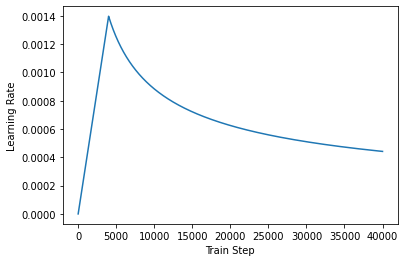

In [25]:
ratioAprendizaje=ProgramarOptimizacion(d)
optimizador=tf.keras.optimizers.Adam(ratioAprendizaje, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

ratioAprendizajeProgramadoTemporal=ProgramarOptimizacion(d)

plt.plot(ratioAprendizajeProgramadoTemporal(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#Text(0.5, 0, 'Train Step')

In [26]:
objetoPerdido = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def funcionPerdida(real, predicho):
  mascara = tf.math.logical_not(tf.math.equal(real, 0))
  perdido = objetoPerdido(real, predicho)

  mascara = tf.cast(mascara, dtype=perdido.dtype)
  perdido *= mascara
  
  return tf.reduce_mean(perdido)/tf.reduce_sum(mascara)

def funcionExactitud(real, prediccion):
  exactitudes= tf.equal(real, tf.argmx(prediccion, axis=2))

  mascara= tf.math.logical_not(tf.math.equal(real,0))
  exactitudes= tf.math.logical_and(mascara, exactitudes)

  exactitudes= tf.cast(exactitudes, dtype=tf.float32)
  mascara=tf.cast(mascara, dtype=tf.float32)
  return tf.reduce_sum(exactitudes)/tf.reduce_sum(mascara)

def exactitud(real, prediccion):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  real = tf.reshape(real, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(real, prediccion)


In [27]:
entrenamientoPerdidos = tf.keras.metrics.Mean(name='train_loss') #train_loss #entrenamientoPerdidos
entrenamientoPrecision = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy') # #entrenamientoPrecision


# Entrenamiento y puntos de control #

In [28]:
transformador = Transformer(numeroCapas, d, numeroCabeceras, dff,
                          tamañoVocabulario, tamañoVocabulario, 
                          posicionesEntrada=tamañoVocabulario, posicionesSalida=tamañoVocabulario,
                          ratio=ratioDespreciar)


In [29]:
def crearMascara(entrada, salida):
  mascaraCodificadaEmpaquetada = crearMascaraEmpaquetada(entrada)
  mascaraDecodificadaEmpaquetada = crearMascaraEmpaquetada(entrada)
  mascaraAlFrente = crearMascaraAlFrente(tf.shape(salida)[1])
  mascaraDecodificadaEmpaqutadaObjetivo = crearMascaraEmpaquetada(salida)
  
  mascarasCombinadas = tf.maximum(mascaraDecodificadaEmpaqutadaObjetivo, mascaraAlFrente)
  return mascaraCodificadaEmpaquetada, mascarasCombinadas, mascaraDecodificadaEmpaquetada


In [30]:
ficheroPuntoControl="./modelos/seq2seq/"
puntoControl=tf.train.Checkpoint(transformer=transformador, optimizer=optimizador)

manejarPuntoControl=tf.train.CheckpointManager(puntoControl, ficheroPuntoControl, max_to_keep=5)

if manejarPuntoControl.latest_checkpoint:
  puntoControl.restore(manejarPuntoControl.latest_checkpoint)
  print ('Restauramos el último punto de control')


Restauramos el último punto de control


In [31]:
condicionesEntrenamiento = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=condicionesEntrenamiento)
def pasoEntrenamiento(entrada, objetivo):
  entradaObjetivo = objetivo[:, :-1]
  objetivoReal = objetivo[:, 1:]
  #entradaObjetivo = objetivo
  #objetivoReal = objetivo
  #print(entradaObjetivo)
  
  mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada = crearMascara(entrada,entradaObjetivo)
  #print(mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada)
  
  with tf.GradientTape() as cadenaEntrada:
    #cadenaEntrada.watch(transformador.trainable_variables)
    prediccion, _ = transformador(entrada, entradaObjetivo, 
                                 True, 
                                 mascaraCodificadaEmpaquetada, 
                                 mascaraCombinada, 
                                 mascaraDecodificadaEmpaquetada)
    perdidas = funcionPerdida(objetivoReal, prediccion)
    #print(perdidas)
  #print(transformador.trainable_variables)
  gradientes = cadenaEntrada.gradient(perdidas, transformador.trainable_variables)  
  #print(list(zip(gradiente, transformador.trainable_variables))[1])  
  optimizador.apply_gradients(zip(gradientes, transformador.trainable_variables))
  
  entrenamientoPerdidos(perdidas)
  entrenamientoPrecision(objetivoReal,prediccion)

In [32]:
#model=Transformer(numeroCapas, d, numeroCabeceras, dff,
#                          tamañoVocabularioEntrada, tamañoVocabularioSalida, 
#                          posicionesEntrada=tamañoVocabularioEntrada, posicionesSalida=tamañoVocabularioSalida,
#                          ratio=ratioDespreciar)
#model.compile(optimizer=optimizador, loss=funcionPerdida, metrics=[exactitud])

#EPOCHS = 20

#model.fit(datosEntrenamiento, epochs=EPOCHS)

## Entrenar ##

In [33]:
EPOCAS=500
for epoca in range(EPOCAS):
  tiempoInicial = time.time()
  
  entrenamientoPerdidos.reset_states()
  entrenamientoPrecision.reset_states()
  for (i, (entrada,respuesta)) in enumerate(datosEntrenamiento):
    pasoEntrenamiento(entrada, respuesta)
    if i % 50 == 0:
      print ('Epoca {} Lote {} Perdida {:.4f} Precisión {:.4f}'.format(
          epoca + 1, i, entrenamientoPerdidos.result(), entrenamientoPrecision.result()))
      
  if (epoca + 1) % 5 == 0:
    puntoControlGuardado = manejarPuntoControl.save()
    print ('Salvando punto de control en la epoca {} a {}'.format(epoca+1,
                                                         puntoControlGuardado))
    
  print ('Epoca {} Perdida {:.4f} Precisión {:.4f}'.format(epoca + 1, 
                                                entrenamientoPerdidos.result(), entrenamientoPrecision.result()))

  print ('Tiempo que tomo desde la primera cada epoca: {} secs\n'.format(time.time() - tiempoInicial))


Perdida 0.0000 Precisión 0.1840
Epoca 221 Lote 50 Perdida 0.0000 Precisión 0.1868
Epoca 221 Perdida 0.0000 Precisión 0.1873
Tiempo que tomo desde la primera cada epoca: 11.210962772369385 secs

Epoca 222 Lote 0 Perdida 0.0000 Precisión 0.1907
Epoca 222 Lote 50 Perdida 0.0000 Precisión 0.1895
Epoca 222 Perdida 0.0000 Precisión 0.1875
Tiempo que tomo desde la primera cada epoca: 11.099783897399902 secs

Epoca 223 Lote 0 Perdida 0.0000 Precisión 0.1700
Epoca 223 Lote 50 Perdida 0.0000 Precisión 0.1869
Epoca 223 Perdida 0.0000 Precisión 0.1873
Tiempo que tomo desde la primera cada epoca: 11.222052335739136 secs

Epoca 224 Lote 0 Perdida 0.0000 Precisión 0.2079
Epoca 224 Lote 50 Perdida 0.0000 Precisión 0.1889
Epoca 224 Perdida 0.0000 Precisión 0.1872
Tiempo que tomo desde la primera cada epoca: 11.135547161102295 secs

Epoca 225 Lote 0 Perdida 0.0000 Precisión 0.1818
Epoca 225 Lote 50 Perdida 0.0000 Precisión 0.1876
Salvando punto de control en la epoca 225 a ./modelos/seq2seq/ckpt-123
Epo

KeyboardInterrupt: 

## PRUEBA ##

In [41]:
def tokenizar(frase):
    palabras=frase.split(" ")
    resultado=[]
    for palabra in palabras:
        palabra=palabra.lower()
        if palabra in diccionario:
            #diccionario.append(palabra)
            resultado.append(diccionario.index(palabra))
    #resultado.append(0)
    return resultado
def desTokenizar(entrada):
    frase=""
    for e in entrada:
        #print(e)
        frase+=(" " if len(frase)>0 else "")+diccionario[e]
    return frase

In [39]:
def respuesta(entrada):
    # inp sentence is portuguese, hence adding the start and end token
    entrada = tokenizar(entrada)
    entrada = tf.expand_dims([1]+entrada+[2], 0)

    print(entrada)
  
    salida = [1]
    print(salida)
    salida = tf.expand_dims(salida, 0)
    print(salida)

    for i in range(100):
        mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada = crearMascara(entrada,salida)
        prediccion, pesosAtencion = transformador(entrada, salida, False, mascaraCodificadaEmpaquetada, mascaraCombinada, mascaraDecodificadaEmpaquetada)
        prediccion = prediccion[: ,-1:, :]
        prediccionID=tf.cast(tf.argmax(prediccion, axis=-1), tf.int32)
        #print("Pred",prediccionID)
        if tf.equal(prediccionID,2):
            break
        #print(prediccionID)
        salida=tf.concat([salida,prediccionID], axis=-1)


        #if predicted_id == tokenizer_en.vocab_size+1:
        #    return tf.squeeze(output, axis=0), attention_weights

    return tf.squeeze(salida, axis=0), pesosAtencion


In [44]:
#entrada="Hola como estas"
entrada="¿que te pasa?"
#entrada="Eres una máquina"
resultado, pesos = respuesta(entrada)
print(resultado)
#respuestaPredicha = desTokenizar([i for i in resultado if i != 0])  
respuestaPredicha = desTokenizar(resultado[1:])  
print('Entrada: {}'.format(entrada))
print('Respuesta: {}'.format(respuestaPredicha))


tf.Tensor([[ 1 92  2]], shape=(1, 3), dtype=int32)
[1]
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor(
[   1 1694    6   63   20 1742 1743    9    6  487   29   26  128   16
   16   16    9], shape=(17,), dtype=int32)
Input: ¿que te pasa?
Predicted translation: < ¿ quién es esta persona ? ¿ estamos en lo cierto . . . ?


In [44]:
#tamañoVocabularioEntrada
def guardaDiccionario:
    with open("modelos/vocabulario_s2s.txt",mode="w",encoding="utf8") as fichero:
        for palabra in diccionario:
            fichero.write(palabra)
    #diccionario
    #np.savetxt("modelos/vocabulario_s2s.csv",diccionario,delimiter="\t")

In [45]:
len(diccionario)


SyntaxError: invalid syntax (<ipython-input-45-5450f5f46dd6>, line 2)

In [49]:
tf.train.list_variables(tf.train.latest_checkpoint(ficheroPuntoControl))



icacion/2/capaNormal1/gamma/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal1/gamma/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/beta/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/beta/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/beta/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/gamma/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/gamma/.OPTIMIZER_SLOT/optimizer/m/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transformer/decodificador/capasDecodificacion/2/capaNormal2/gamma/.OPTIMIZER_SLOT/optimizer/v/.ATTRIBUTES/VARIABLE_VALUE',
  [128]),
 ('transform